In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from time import time
%matplotlib inline

<h1>Funções e Variáveis Auxiliares</h1>

In [4]:
# Starting from Sunday, as day 1 of july
week_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
correct_day_day_of_week = {str(i).zfill(2): week_days[(i-1)%7] for i in range(1, 32)}

In [38]:
def compareFloats(num1, num2, eps = 0.00001, onlyEquality=True):
    '''
        # Método que compara 2 floats até certa precisão
        # Exemplo:
        # a = 1.55555; b = 1.55566; eps = 0.0001
        # Para o eps acima, a < b, enquanto, para eps = 0.001, a == b
    '''
    subtr = num1-num2
    if subtr < eps:
        return False
    elif onlyEquality:
        return True
    else:
        return 1 if subtr > 0 else -1

In [8]:
dataset = pd.read_csv('testdata.csv')

In [9]:
dataset.head()

,user,latitude,longitude,date,day_of_week,hour,categoria,timestamp
0,User_3401,-26.489503,-49.028018,2018-07-08,Saturday,18,bakery,1531604419436
1,User_539,-14.457400,-46.433148,2018-07-08,Sunday,7,restaurant,1531650749377
2,User_789,-8.903859,-36.487485,2018-07-08,Saturday,9,night_club,1531571345816
3,User_2814,-22.823960,-43.012243,2018-07-08,Saturday,22,store,1531619273330
4,User_3432,-24.949576,-53.488507,2018-07-08,Sunday,3,restaurant,1531634482205


<h1>Análise dos Dados</h1>
<p>Inicialmente podemos analisar o dataset buscando valores únicos que podem retornar algum insight.</p>

<h2>Limpando o Dataset</h2>
<p>Através de algumas análises de colunas, notei que alguns valores são irelevantes:</p>
<ul>
    <li>Posso substituir a coluna de data por uma só contendo os dias do mês. Todas as datas são do mês 7</li>
    <li>Timestamp é irelevante dado que a tabela já contém dia, mês, ano, dia da semana e hora. A única relevancia seria especificar ainda mais além do que já é dado. Além disso o timestamp não está bem formatado e, tentando corrigir, as datas não batem com o que é dado nas outras colunas</li>
</ul>

In [10]:
curr_timestamp = time()
first_timestamp_ds = dataset['timestamp'][0]
print('Comparando Timestamps:')
print('%f\n%.d'%(curr_timestamp, first_timestamp_ds))

Comparando Timestamps:
1532093740.565796
1531604419436


<p>Comparando o tamanho dos dois notei que o timestamp do dataset não possui decimal, porém é 4 dígitos maior do que um timestamp correto. Deduzi que esses dígitos a mais seria decimal. Então consertei e comparei a data com o novo timestamp e a data presente no dataset:</p>

In [11]:
# for _, row in dataset[['hour','date','timestamp']].iterrows():
#     datetime_ts = dt.utcfromtimestamp(row['timestamp']/1000)
#     print(datetime_ts.date(), datetime_ts.hour, end = '\t')
#     print(row['date'], row['hour'])

<p>Houve uma inconsistência no dia ou na hora.</p>

In [12]:
dataset = dataset.drop(columns=['timestamp'])

<p>Comparando o dataset completo com aquele filtrando pelo mês 7 de 2018:</p>

In [13]:
dataset[dataset['date'].str.contains(r'2018-07-*.')].shape== dataset.shape

True

In [14]:
dataset['date'] = dataset['date'].apply(lambda date_str: date_str[-2:])
dataset.rename(columns={'date': 'dia'}, inplace=True)

<h2>Novo Dataset</h2>
<p>Dataset após todas as mudanças anteriores</p>

In [15]:
dataset.head()

,user,latitude,longitude,dia,day_of_week,hour,categoria
0,User_3401,-26.489503,-49.028018,08,Saturday,18,bakery
1,User_539,-14.457400,-46.433148,08,Sunday,7,restaurant
2,User_789,-8.903859,-36.487485,08,Saturday,9,night_club
3,User_2814,-22.823960,-43.012243,08,Saturday,22,store
4,User_3432,-24.949576,-53.488507,08,Sunday,3,restaurant


<h2>Analisando Atributos Isoladamente</h2>
<p>Em uma primeira passada pela base de dados podemos extrair várias informações com base nas colunas. O objetivo dessa sessão é tentar visualizar o máximo de informação de cada coluna.</p>

<h3>Day of Week</h3>
<p>Analisando os dias da semana é possível discutir qual o melhor dia da semana para se vincular uma campanha.</p>

In [16]:
dataset['day_of_week'].value_counts()

Thursday     4735
Friday       4542
Wednesday    4500
Tuesday      4477
Sunday       4415
Saturday     4187
Monday       3946
Name: day_of_week, dtype: int64

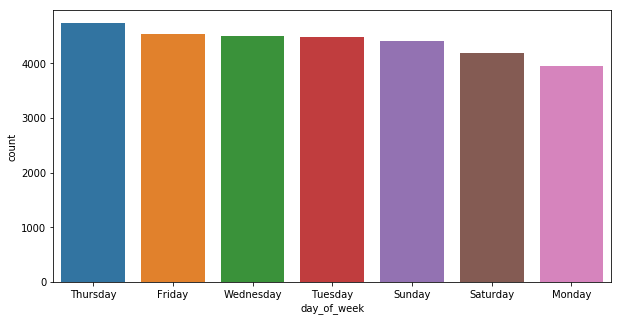

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(data=dataset, 
              x='day_of_week', 
              order=dataset['day_of_week'].value_counts().index)
plt.show()

<p>Notamos claramente que o dia com maior movimentação de clientes é Quinta-feira e o dia com menor movimentação é Segunda-Feira, porém os valores entre [Sexta-feira, Terça-feira] acima não variam muito entre si e mantém um valor acima aos 3 últimos. É possível imaginar que os melhores dias para se vincular uma campanha seja Terça, Quarta, Quinta e Sexta.</p>

<h3>Hour</h3>
<p>A partir da coluna de horas é possível saber qual o melhor horário para vincular uma campanha com base no número de usuários presentes em estabelecimentos, assim como os piores horários.</p>

In [14]:
hour_count = dataset['hour'].value_counts()
hour_count[:5]

12    2474
13    2397
14    1966
18    1884
17    1880
Name: hour, dtype: int64

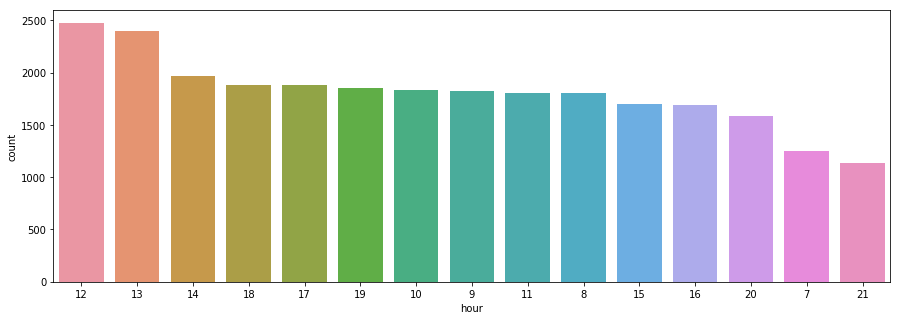

In [18]:
plt.figure(figsize=(15,5))
sns.countplot(data = dataset, x = 'hour', order=dataset['hour'].value_counts()[:15].index)
plt.show()

In [19]:
# Quais são as horas cuja sua contagem é superior a mediana das contagens
hour_count[hour_count > hour_count.median()].keys().sort_values()

Int64Index([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

<p>A partir do array acima temos uma faixa de horário ideal para rodar um anúncio de promoção.</p>

<h3>Dia</h3>
<p>A análise do dia que houve a visita pode não ser tão clara, talvez a análise do dia da semana traga mais informações. Porém, se temos um dia sobressalente entre os demais e foge um pouco do padrão dos dias da semana, talvez aquele dia possa ser um feriado ou um dia especial como, por exemplo, um jogo de copa do mundo.</p>

In [16]:
contagem_por_dia = dataset['dia'].value_counts().sort_index()
contagem_por_dia

01    1605
02    1875
03    2259
04    2340
05    2468
06    2253
07    2155
08    1643
09    2071
10    2218
11    2160
12    2267
13    2289
14    2032
15    1167
Name: dia, dtype: int64

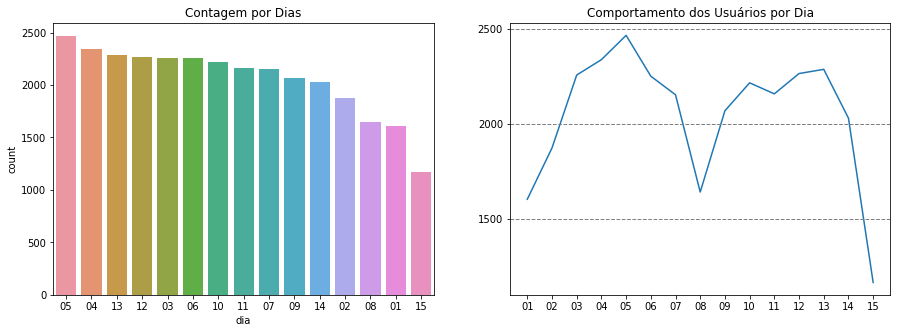

In [71]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Contagem por Dias')
sns.countplot(data=dataset, x='dia', order=contagem_por_dia.sort_values(ascending=False).index)
plt.subplot(122)
plt.title('Comportamento dos Usuários por Dia')
plt.plot(contagem_por_dia)
yticks_array = [place for place in range(1000, 3000, 500)]
plt.yticks(yticks_array[1:])
for place in yticks_array[1:]:
    plt.axhline(place, ls='--', c='gray', lw=1)
plt.show()

<p>Pelo gráfico da direita podemos ver quais os dias mais agitados do mês (até agora). Vemos que o dia 5 foi o dia mais movimentado, e essa contagem vai decrescendo suavemente até o dia 02, onde a queda foi mais brusca. Analisando o gráfico da direita podemos ver como os usuários se comporta em uma linha temporal. Notamos uma sazonalidade (os vales do gráfico estão mais ou menos separados pela mesma "distância". Notamos também o vale global do gráfico no dia 15 em ambas as tabelas e, coincidentemente, o dia 15 foi a final da copa do mundo.</p>

In [38]:
menores_dias = list(contagem_por_dia.sort_values().index)[:7]
menores_dia_da_semana = pd.Series([correct_day_day_of_week[day] for day in menores_dias]).value_counts()
menores_dia_da_semana

Sunday      3
Monday      2
Saturday    2
dtype: int64

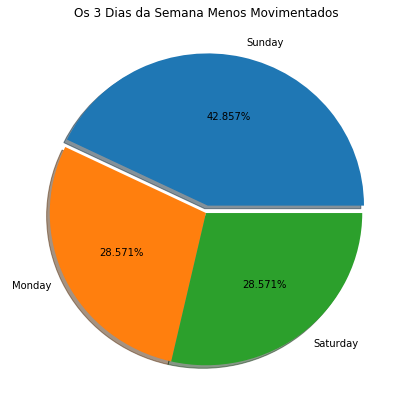

In [41]:
plt.figure(figsize=(7,7))
plt.title('Os %d Dias da Semana Menos Movimentados'%(len(menores_dia_da_semana)))
plt.pie(menores_dia_da_semana, 
        labels=menores_dia_da_semana.index, 
        autopct='%.3f%%',
        explode=[0.05] + [0]*(len(menores_dia_da_semana)-1), # in case there is a unknown number of elements
        shadow=True)
plt.show()

<h3>Categoria</h3>
<p>A partir da categoria dos estabelecimentos podemos prever qual a categoria mais visitada por clientes, daí vincular propagandas mais direcionadas a esse público.</p>

In [22]:
dataset['categoria'].value_counts()[:5]

restaurant                5826
store                     3461
school                    1728
doctor                    1203
grocery_or_supermarket    1103
Name: categoria, dtype: int64

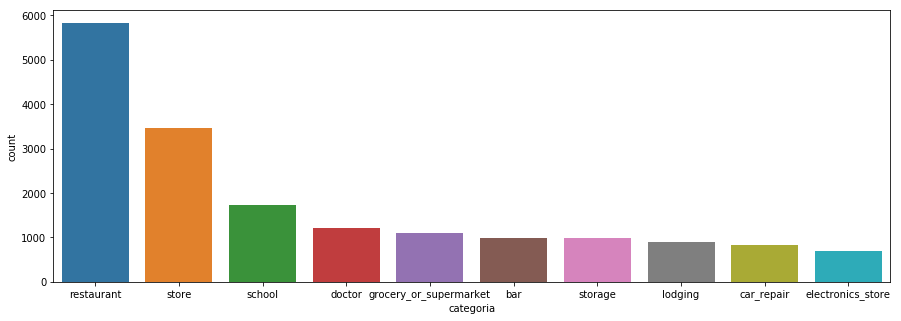

In [23]:
plt.figure(figsize=(15,5))
sns.countplot(data=dataset, x = 'categoria', order=dataset['categoria'].value_counts()[:10].index)
plt.show()

<p>No gráfico anterior temos as 10 categorias mais visitadas por usuários e, mesmo entre essas 10, notamos o destaque para restaurantes. No mês de Julho, restaurantes foram os estabelecimentos mais visitados, sendo visitado quase o dobro de vezes que o segundo colocado, que seriam lojas em geral.</p>

<h2>Analisando Colunas e Suas Relações</h2>
<p>Inicialmente analisei as colunas isoladamente procurando dados interessantes (por exemplo: agora sei que restaurante é o estabelecimento mais visitado de Julho; 12 horas é o horário mais ativo para consumidores). Agora nos resta analisar qual a relação de uma coluna sobre a outra.</p>

In [42]:
a = dataset['dia'].value_counts().sort_index()
a

01    1605
02    1875
03    2259
04    2340
05    2468
06    2253
07    2155
08    1643
09    2071
10    2218
11    2160
12    2267
13    2289
14    2032
15    1167
Name: dia, dtype: int64